In [0]:
# Copyright 2019 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# UNet Industrial Inference Demo with TF-TRT

## Overview


In this notebook, we will demo the process of carrying out inference on new images using a pre-trained UNet model downloaded from the NVIDIA NGC Model registry. We will also optimize the naitive TensorFlow trained model for deployment with TensorFlow-TensorRT (TF-TRT). TensorRT is the NVIDIA high-performance runtime environment for deployment of deep learning applications. TF-TRT is the integration of TensorRT directly into the TensorFlow ecosystem, allowing users to benefit much improved performance using a relatively easy and convenient Python API interfance. 


### Requirement
1. Before running this notebook, please set the Colab runtime environment to GPU via the menu *Runtime => Change runtime type => GPU*.

For TF-TRT FP16 and INT8 inference, an NVIDIA Volta, Turing or newer GPU generations is required. 

In [0]:
!nvidia-smi

Fri Sep 27 04:28:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    72W / 149W |   6601MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  


2. Install TensorFlow GPU 1.15.0



In [ ]:
!pip install tensorflow-gpu==1.15.0-rc1

The below code check whether a Tensor core GPU is present.

In [0]:
from tensorflow.python.client import device_lib

def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: None


3. Next, we clone the Github UNet_Industrial repository and set up the workspace.

In [ ]:
!git clone https://github.com/NVIDIA/DeepLearningExamples

In [0]:
import os

WORKSPACE_DIR='/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks'
os.chdir(WORKSPACE_DIR)
print (os.getcwd())

/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks


## Data download

We will first download some data, in particular, the [Weakly Supervised Learning for Industrial Optical Inspection (DAGM 2007)](https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html) dataset. 

> The competition is inspired by problems from industrial image processing. In order to satisfy their customers' needs, companies have to guarantee the quality of their products, which can often be achieved only by inspection of the finished product. Automatic visual defect detection has the potential to reduce the cost of quality assurance significantly.
>
> The competitors have to design a stand-alone algorithm which is able to detect miscellaneous defects on various background textures.
>
> The particular challenge of this contest is that the algorithm must learn, without human intervention, to discern defects automatically from a weakly labeled (i.e., labels are not exact to the pixel level) training set, the exact characteristics of which are unknown at development time. During the competition, the programs have to be trained on new data without any human guidance.

**Source:** https://resources.mpi-inf.mpg.de/conference/dagm/2007/prizes.html


In [0]:
! ./download_and_preprocess_dagm2007_public.sh ./data


################################################
Processing Public Dataset
################################################

Archive:  /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class1.zip
Archive:  /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class1_def.zip
Archive:  /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class2.zip
Archive:  /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class2_def.zip
Archive:  /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class3.zip
Archive:  /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class3_def.zip
Archive:  /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/notebooks/data/zip_files/public/Class4.zip
A

The final data directory should look like:

```
./data
  raw_images
      public
          Class1	    
          Class2	
          Class3	    
          Class4	
          Class5	    
          Class6
          Class1_def  
          Class2_def	
          Class3_def  
          Class4_def	
          Class5_def  
          Class6_def
      private
  zip_files
```

Each data directory contains training images corresponding to one of 6 types of defects.

## Model download from NVIDIA NGC model repository

NVIDIA provides pretrained UNet models along with many other deep learning models such as ResNet, BERT, Transformer, SSD... at https://ngc.nvidia.com/catalog/models. Here, we will download and upzip pretrained UNet models. 

In [0]:
%%bash 
wget -nc -q --show-progress -O unet_model.zip \
https://api.ngc.nvidia.com/v2/models/nvidia/unetindustrial_for_tensorflow_32/versions/1/zip
unzip -o ./unet_model.zip

Archive:  ./unet_model.zip
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/checkpoint  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/graph.pbtxt  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500.data-00000-of-00002  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500.data-00001-of-00002  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500.index  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500.meta  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/checkpoint  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/graph.pbtxt  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/model.ckpt-2500.data-00000-of-00002  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/model.ckpt-2500.data-00001-of-00002  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Class+10/model.ckpt-2500.index  
  inflating: JoC_UNET_Industrial_FP32_TF_20190522/Cla

Upon completion of the download, the following model directories should exist, containing pre-trained model corresponding to 10 classes of the DAGM 2007 competition data set.

In [0]:
!ls JoC_UNET_Industrial_FP32_TF_20190522

Class+1   Class+2  Class+4  Class+6  Class+8
Class+10  Class+3  Class+5  Class+7  Class+9


## Inference with Naitive TensorFlow

We will now launch an interactive testing, where you can load new test images. First, we load some required libraries and define some helper functions to load the pretrained UNet model.

In [0]:
!pip install ../dllogger

import tensorflow as tf
print(tf.__version__)

try:
    __import__("horovod")
except ImportError:
    os.system("pip install horovod")
    

    
import horovod.tensorflow
import sys
sys.path.insert(0,'/content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial')

from model.unet import UNet_v1

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Processing /content/DeepLearningExamples/TensorFlow/Segmentation/UNet_Industrial/dllogger
  Created wheel for DLLogger: filename=DLLogger-0.3.1-cp36-none-any.whl size=9884 sha256=294b0b226bb82109933049017fcab2268b6a282b616790276b0a2af8763ed245
  Stored in directory: /tmp/pip-ephem-wheel-cache-kpseamaa/wheels/23/a4/72/2606d992c53ecdd7969c79ed3fb0c23dacdbdb438a8c17999a
Successfully built DLLogger
  Found existing installation: DLLogger 0.3.1
    Uninstalling DLLogger-0.3.1:
      Successfully uninstalled DLLogger-0.3.1


1.15.0-rc1


We will now load and inspect one defect image from Class 1.

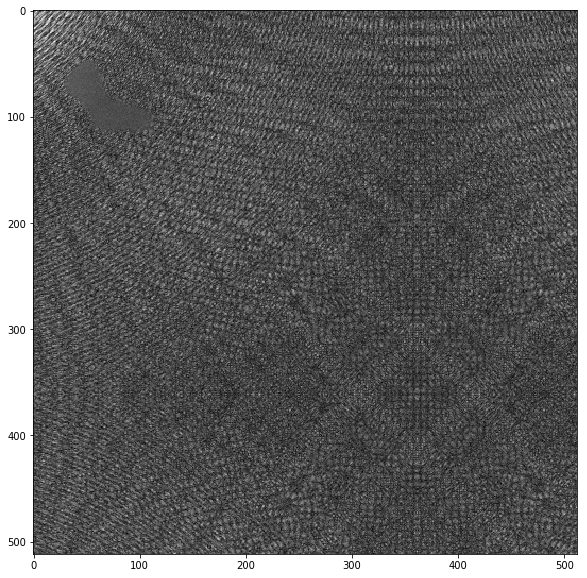

In [0]:
img = mpimg.imread('./data/raw_images/public/Class1_def/1.png')

plt.figure(figsize = (10,10))
plt.imshow(img, cmap='gray')

As we can see in this figure, there exists a defective area in the top left corner. We will now load the model and carry out inference on the normalized test image.

In [0]:
# Image preprocessing
img =  np.expand_dims(img, axis=2)
img =  np.expand_dims(img, axis=0)
img = (img-0.5)/0.5

In [ ]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        network = UNet_v1(
            model_name="UNet_v1",
            input_format='NHWC',
            compute_format='NHWC',
            n_output_channels=1,
            unet_variant='tinyUNet',
            weight_init_method='he_uniform',
            activation_fn='relu'
        )
        
        tf_input = tf.placeholder(tf.float32, [None, 512, 512, 1], name='input')
        
        outputs, logits = network.build_model(tf_input)
        saver = tf.train.Saver()

        # Restore variables from disk.
        saver.restore(sess, "JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500")
        
        
        output = sess.run([outputs, logits], feed_dict={tf_input: img})
        


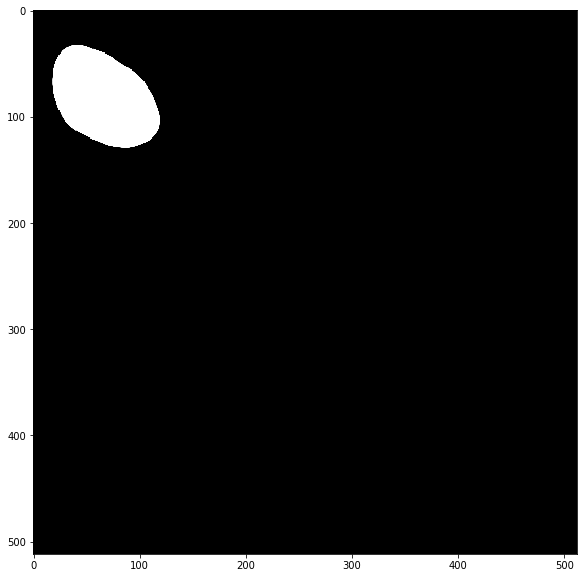

In [0]:
# Print out model predicted mask
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(output[0]), cmap='gray')

As expected, the model points out the correct defective area in this image. Please feel free to try out other defective images within `./data/raw_images/public/Class1_def/`

In [0]:
!ls ./data/raw_images/public/Class1_def/

100.png  116.png  131.png  147.png  26.png  41.png  57.png  72.png  88.png
101.png  117.png  132.png  148.png  27.png  42.png  58.png  73.png  89.png
102.png  118.png  133.png  149.png  28.png  43.png  59.png  74.png  8.png
103.png  119.png  134.png  14.png   29.png  44.png  5.png   75.png  90.png
104.png  11.png   135.png  150.png  2.png   45.png  60.png  76.png  91.png
105.png  120.png  136.png  15.png   30.png  46.png  61.png  77.png  92.png
106.png  121.png  137.png  16.png   31.png  47.png  62.png  78.png  93.png
107.png  122.png  138.png  17.png   32.png  48.png  63.png  79.png  94.png
108.png  123.png  139.png  18.png   33.png  49.png  64.png  7.png   95.png
109.png  124.png  13.png   19.png   34.png  4.png   65.png  80.png  96.png
10.png	 125.png  140.png  1.png    35.png  50.png  66.png  81.png  97.png
110.png  126.png  141.png  20.png   36.png  51.png  67.png  82.png  98.png
111.png  127.png  142.png  21.png   37.png  52.png  68.png  83.png  99.png
112.png  128.png  143.png  

# Optimize model and inference with TF-TRT

In this section, instead of doing inference with the naitive TensorFlow environment, we will first optimize the model with TF-TRT, then doing inference.

We first need to install NVIDIA TensorRT 5.0 runtime environment on Colab.

In [0]:
%%bash
wget https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb

dpkg -i nvidia-machine-learning-repo-*.deb
apt-get update

(Reading database ... 131335 files and directories currently installed.)
Preparing to unpack nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb ...
Unpacking nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) over (1.0.0-1) ...
Setting up nvidia-machine-learning-repo-ubuntu1804 (1.0.0-1) ...
Ign:1 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.ne

--2019-09-27 04:36:43--  https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 192.229.232.112, 2606:2800:247:2063:46e:21d:825:102e
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|192.229.232.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2926 (2.9K) [application/x-deb]
Saving to: ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.3’

     0K ..                                                    100% 94.3M=0s

2019-09-27 04:36:43 (94.3 MB/s) - ‘nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb.3’ saved [2926/2926]

W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
W: Target Packages (Packages) is configured multiple times in /etc/apt/sourc

In [0]:
!sudo apt-get install libnvinfer5
!dpkg -l | grep TensorRT

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libnvinfer5 is already the newest version (5.1.5-1+cuda10.1).
0 upgraded, 0 newly installed, 0 to remove and 125 not upgraded.
W: Target Packages (Packages) is configured multiple times in /etc/apt/sources.list.d/nvidia-machine-learning.list:1 and /etc/apt/sources.list.d/nvidia-ml.list:1
ii  libnvinfer-dev                          6.0.1-1+cuda10.1                                  amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev                   6.0.1-1+cuda10.1                                  amd64        TensorRT plugin libraries
ii  libnvinfer-plugin6                      6.0.1-1+cuda10.1                                  amd64        TensorRT plugin libraries
ii  libnvinfer5                             5.1.5-1+cuda10.1                                  amd64        TensorRT runtime libraries
ii  libnvinfer6                             6.0.1-1+cuda10.1     

A successful TensorRT installation should look like:

```
ii  libnvinfer5                             5.1.5-1+cuda10.1                                  amd64        TensorRT runtime libraries
```

Next, we are ready to optimize the model for inference with TF-TRT. This is carried out in the following steps:

- First, we convert the model checkpoint to a frozen graph that is more relevant for deployment.

- Next, we employ TF-TRT to optimize and convert the frozen graph into a TF-TRT graph. This graph can be employed for inference within the TensorFlow environment, but the underlying runting will be TensorRT. 

**Precision mode:** The model that TF-TRT optimizes can have the graph or parameters stored in float32 (FP32) or float16 (FP16). Regardless of the datatype of the model, TensorRT can convert tensors and weights to lower precisions during the optimization. The argument `precision_mode` sets the precision mode; which can be one of FP32, FP16, or INT8

## FP32 Inference

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

SAVED_MODEL_DIR = './TR-TRT-model-FP32'

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        network = UNet_v1(
            model_name="UNet_v1",
            input_format='NHWC',
            compute_format='NHWC',
            n_output_channels=1,
            unet_variant='tinyUNet',
            weight_init_method='he_uniform',
            activation_fn='relu'
        )
        
        tf_input = tf.placeholder(tf.float32, [None, 512, 512, 1], name='input')
        
        outputs, logits = network.build_model(tf_input)
        
        #print output nodes names
        print(outputs)
        print(logits)
        
        saver = tf.train.Saver()

        # Restore variables from disk.
        saver.restore(sess, "JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500")
        
        # Freeze the graph:
        frozen_graph = tf.graph_util.convert_variables_to_constants(sess,
                                                                    tf.get_default_graph().as_graph_def(),
                                                                    output_node_names=['UNet_v1/sigmoid', 
                                                                                       'UNet_v1/ouputs_block/conv2d_2/BiasAdd'])

        # Now you can create a TensorRT inference graph from your frozen graph:
        converter = trt.TrtGraphConverter(input_graph_def=frozen_graph,
                                          nodes_blacklist=['UNet_v1/sigmoid', 'UNet_v1/ouputs_block/conv2d_2/BiasAdd'],
                                          precision_mode='FP32' ) #output nodes
        trt_graph = converter.convert()



After this step, the TF-TRT optimized model is stored in `trt_graph`. Next, we carry out inference using this graph. We will also save the TF-TRT graph into a save model which is ready for deployment later elsewhere.

In [0]:
!rm -r $SAVED_MODEL_DIR
graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        # Import the TensorRT graph into a new graph and run:
        output_node = tf.import_graph_def(trt_graph, return_elements=['UNet_v1/sigmoid', 'UNet_v1/ouputs_block/conv2d_2/BiasAdd'], name="")
    
        output = sess.run(["UNet_v1/sigmoid:0"], feed_dict={"input:0": img})

        #Optionally, save model for serving if an ouput directory argument is presented
        if SAVED_MODEL_DIR:
            print('Saving model to %s'%SAVED_MODEL_DIR)
            tf.saved_model.simple_save(
                session=sess,
                export_dir=SAVED_MODEL_DIR,
                inputs={"input":tf.get_default_graph().get_tensor_by_name("input:0")},
                outputs={"mask":tf.get_default_graph().get_tensor_by_name("UNet_v1/sigmoid:0")},
                legacy_init_op=None
             )

rm: cannot remove './TR-TRT-model-FP32': No such file or directory
Saving model to ./TR-TRT-model-FP32
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./TR-TRT-model-FP32/saved_model.pb


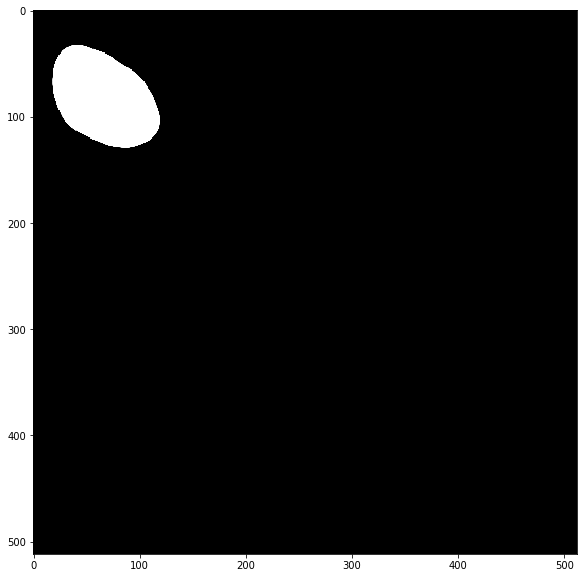

In [0]:
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(output[0]), cmap='gray')

Next, we load the saved TF-TRT model and carry out inference.

In [ ]:
# inference with save TF-TRT model
with tf.Session(graph=tf.Graph(), config=config) as sess:
        tf.saved_model.loader.load(
            sess, [tf.saved_model.tag_constants.SERVING], SAVED_MODEL_DIR)
        nodes = [n.name for n in tf.get_default_graph().as_graph_def().node]
        #print(nodes)
        output = sess.run(["UNet_v1/sigmoid:0"], feed_dict={"input:0": img})

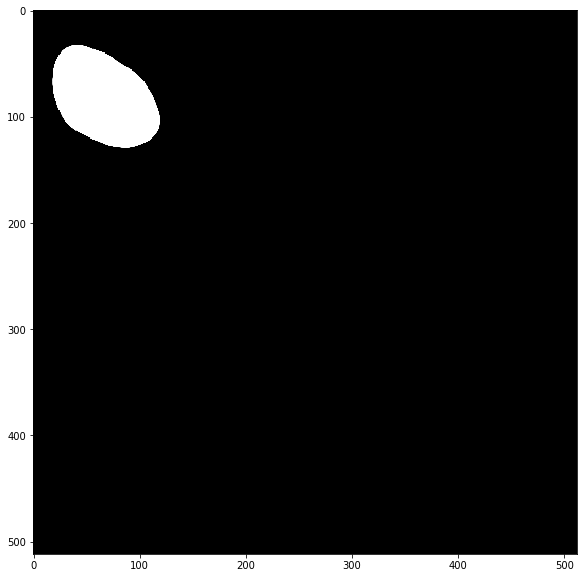

In [0]:
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(output[0]), cmap='gray')

Upon inspecting the node list, we can see nodes such as `UNet_v1/TRTEngineOp_0`, `UNet_v1/TRTEngineOp_1`... These are portions of the naitive TensorFlow graph that has been convert and optimized for TensorRT execution. For parts of the graph that are not convertible, execution is carried out by the native TensorFlow runtime.  

In [0]:
nodes

['input',
 'UNet_v1/input_reshape/initial_zero_padding/resize_image_with_crop_or_pad/assert_positive/Const',
 'UNet_v1/input_reshape/initial_zero_padding/resize_image_with_crop_or_pad/assert_positive/assert_less/Const',
 'UNet_v1/input_reshape/initial_zero_padding/resize_image_with_crop_or_pad/assert_positive/assert_less/Assert/Assert/data_0',
 'UNet_v1/input_reshape/initial_zero_padding/resize_image_with_crop_or_pad/Rank',
 'UNet_v1/input_reshape/initial_zero_padding/resize_image_with_crop_or_pad/assert_greater_equal/y',
 'UNet_v1/input_reshape/initial_zero_padding/resize_image_with_crop_or_pad/assert_greater_equal/All',
 'UNet_v1/input_reshape/initial_zero_padding/resize_image_with_crop_or_pad/assert_greater_equal/Assert/Assert/data_0',
 'UNet_v1/input_reshape/initial_zero_padding/resize_image_with_crop_or_pad/assert_greater_equal/Assert/Assert/data_1',
 'UNet_v1/input_reshape/initial_zero_padding/resize_image_with_crop_or_pad/assert_greater_equal/Assert/Assert/data_2',
 'UNet_v1/inp

## FP16 Inference

Next, we convert the model using FP16 precision.

In [ ]:
SAVED_MODEL_DIR = './TR-TRT-model-FP16'

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        network = UNet_v1(
            model_name="UNet_v1",
            input_format='NHWC',
            compute_format='NHWC',
            n_output_channels=1,
            unet_variant='tinyUNet',
            weight_init_method='he_uniform',
            activation_fn='relu'
        )
        
        tf_input = tf.placeholder(tf.float32, [None, 512, 512, 1], name='input')
        
        outputs, logits = network.build_model(tf_input)
        
        #print output nodes names
        print(outputs)
        print(logits)
        
        saver = tf.train.Saver()

        # Restore variables from disk.
        saver.restore(sess, "JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500")
        
        # Freeze the graph:
        frozen_graph = tf.graph_util.convert_variables_to_constants(sess,
                                                                    tf.get_default_graph().as_graph_def(),
                                                                    output_node_names=['UNet_v1/sigmoid', 
                                                                                       'UNet_v1/ouputs_block/conv2d_2/BiasAdd'])

        # Now you can create a TensorRT inference graph from your frozen graph:
        converter = trt.TrtGraphConverter(input_graph_def=frozen_graph,
                                          nodes_blacklist=['UNet_v1/sigmoid', 'UNet_v1/ouputs_block/conv2d_2/BiasAdd'],
                                          precision_mode='FP16' ) #output nodes
        trt_graph = converter.convert()



In [0]:
!rm -r $SAVED_MODEL_DIR
graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        # Import the TensorRT graph into a new graph and run:
        output_node = tf.import_graph_def(trt_graph, return_elements=['UNet_v1/sigmoid', 'UNet_v1/ouputs_block/conv2d_2/BiasAdd'], name="")
    
        output = sess.run(["UNet_v1/sigmoid:0"], feed_dict={"input:0": img})

        #Optionally, save model for serving if an ouput directory argument is presented
        if SAVED_MODEL_DIR:
            print('Saving model to %s'%SAVED_MODEL_DIR)
            tf.saved_model.simple_save(
                session=sess,
                export_dir=SAVED_MODEL_DIR,
                inputs={"input":tf.get_default_graph().get_tensor_by_name("input:0")},
                outputs={"mask":tf.get_default_graph().get_tensor_by_name("UNet_v1/sigmoid:0")},
                legacy_init_op=None
             )

rm: cannot remove './TR-TRT-model-FP16': No such file or directory
Saving model to ./TR-TRT-model-FP16
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./TR-TRT-model-FP16/saved_model.pb


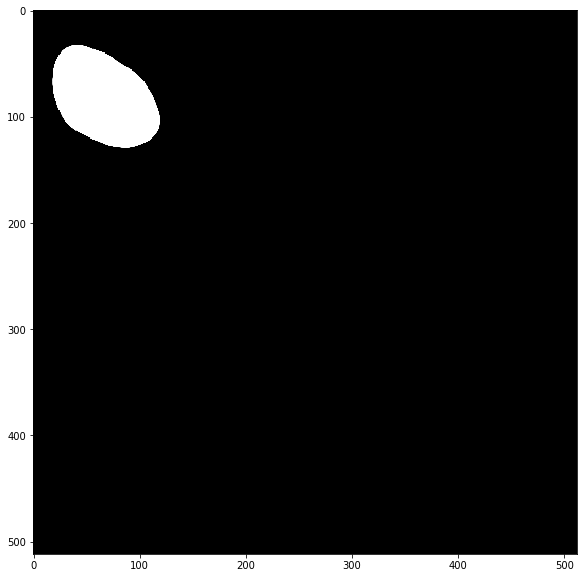

In [0]:
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(output[0]), cmap='gray')

## INT8 Inference

In [ ]:
SAVED_MODEL_DIR = './TR-TRT-model-INT8'

graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        network = UNet_v1(
            model_name="UNet_v1",
            input_format='NHWC',
            compute_format='NHWC',
            n_output_channels=1,
            unet_variant='tinyUNet',
            weight_init_method='he_uniform',
            activation_fn='relu'
        )
        
        tf_input = tf.placeholder(tf.float32, [None, 512, 512, 1], name='input')
        
        outputs, logits = network.build_model(tf_input)
        
        #print output nodes names
        print(outputs)
        print(logits)
        
        saver = tf.train.Saver()

        # Restore variables from disk.
        saver.restore(sess, "JoC_UNET_Industrial_FP32_TF_20190522/Class+1/model.ckpt-2500")
        
        # Freeze the graph:
        frozen_graph = tf.graph_util.convert_variables_to_constants(sess,
                                                                    tf.get_default_graph().as_graph_def(),
                                                                    output_node_names=['UNet_v1/sigmoid', 
                                                                                       'UNet_v1/ouputs_block/conv2d_2/BiasAdd'])

        # Now you can create a TensorRT inference graph from your frozen graph:
        converter = trt.TrtGraphConverter(input_graph_def=frozen_graph,
                                          nodes_blacklist=['UNet_v1/sigmoid', 'UNet_v1/ouputs_block/conv2d_2/BiasAdd'],
                                          precision_mode='INT8' ) #output nodes
        trt_graph = converter.convert()



In [0]:
!rm -r $SAVED_MODEL_DIR
graph = tf.Graph()
with graph.as_default():
    with tf.Session(config=config) as sess:
        # Import the TensorRT graph into a new graph and run:
        output_node = tf.import_graph_def(trt_graph, return_elements=['UNet_v1/sigmoid', 'UNet_v1/ouputs_block/conv2d_2/BiasAdd'], name="")
    
        output = sess.run(["UNet_v1/sigmoid:0"], feed_dict={"input:0": img})

        #Optionally, save model for serving if an ouput directory argument is presented
        if SAVED_MODEL_DIR:
            print('Saving model to %s'%SAVED_MODEL_DIR)
            tf.saved_model.simple_save(
                session=sess,
                export_dir=SAVED_MODEL_DIR,
                inputs={"input":tf.get_default_graph().get_tensor_by_name("input:0")},
                outputs={"mask":tf.get_default_graph().get_tensor_by_name("UNet_v1/sigmoid:0")},
                legacy_init_op=None
             )

rm: cannot remove './TR-TRT-model-INT8': No such file or directory
Saving model to ./TR-TRT-model-INT8
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./TR-TRT-model-INT8/saved_model.pb


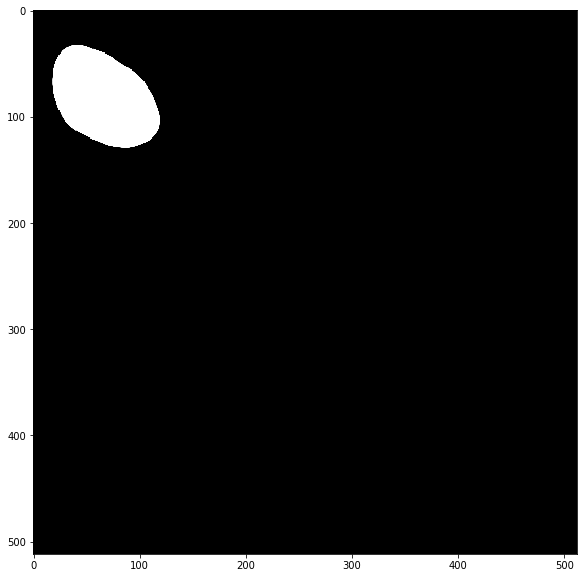

In [0]:
plt.figure(figsize = (10,10))
plt.imshow(np.squeeze(output[0]), cmap='gray')

# Conclusion

In this notebook, we have walked through the complete process of carrying out inference using a pretrained UNet-Industrial model.
## What's next
Now it's time to try the UNet-Industrial model on your own data. 